# (논문) CAT/DOG
> CNN and CAM

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

### import 

In [2]:
import torch 
from fastai.vision.all import *
import cv2

---

### data 

In [3]:
path=untar_data(URLs.PETS)/'images'

In [4]:
path

Path('/home/khy/.fastai/data/oxford-iiit-pet/images')

In [5]:
files=get_image_files(path)

In [6]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

In [7]:
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

Could not do one pass in your dataloader, there is something wrong in it


---

### learn

In [11]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

---

### sample

#### 1st CNN and CAM

In [12]:
get_image_files(path)[0]

Path('/home/khy/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg')

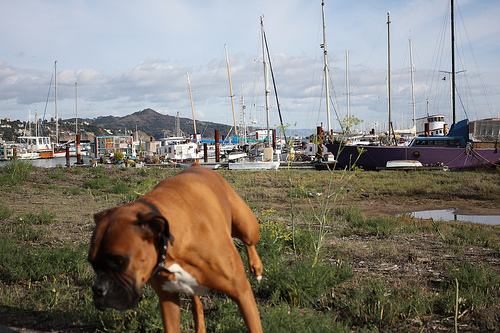

In [13]:
img = PILImage.create(get_image_files(path)[0])
img

In [14]:
x, = first(dls.test_dl([img]))  #이미지 텐서화

In [15]:
x.shape

torch.Size([1, 3, 512, 512])

In [16]:
net1=lrnr.model[0]
net2=lrnr.model[1] 

In [17]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [18]:
net=torch.nn.Sequential(net1,net2)

In [19]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [20]:
lrnr2.fine_tune(15) 

In [21]:
dls.vocab

['cat', 'dog']

- (고양이,강아지)라고 생각한 확률 

In [22]:
a=net(x).tolist()[0][0]
b=net(x).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

(1.752036905842922e-05, 0.9999824796309416)

- CAM

In [23]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

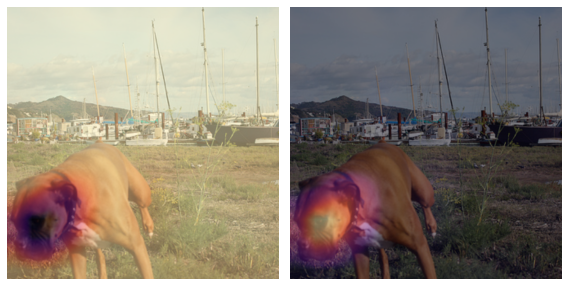

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

---

#### 2nd CNN and CAM

- MODE 1 만들기

    - 가중치 재설정

In [25]:
test=camimg[1]-torch.min(camimg[1])

In [26]:
A1=torch.exp(-0.015*test)  

In [27]:
A2=1-A1

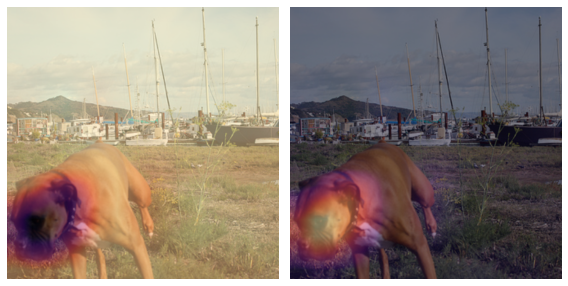

In [47]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A1.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A2.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [29]:
A1.data.to('cpu').shape

torch.Size([16, 16])

In [30]:
X1=np.array(A1.to("cpu").detach(),dtype=np.float32)

In [31]:
Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))

In [32]:
x1=x.squeeze().to('cpu')*Y1   #MODE1을 x1으로 저장

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


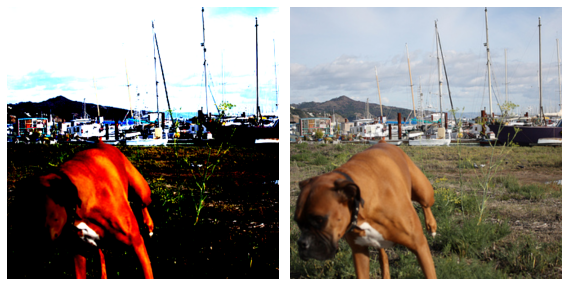

In [49]:
fig, (ax1,ax2) = plt.subplots(1,2) 
#
x1.squeeze().show(ax=ax1)  #MODE1
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [34]:
x1=x1.reshape(1,3,512,512)

In [35]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [36]:
camimg1 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x1).squeeze())

In [37]:
camimg1.shape

torch.Size([2, 16, 16])

- CAM

    - mode1에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


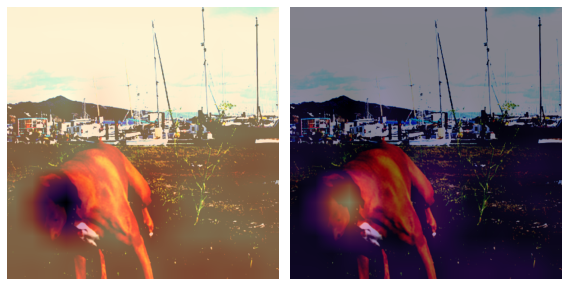

In [50]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
x1.squeeze().show(ax=ax1)
ax1.imshow(camimg1[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
x1.squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째 CAM결과와 비교

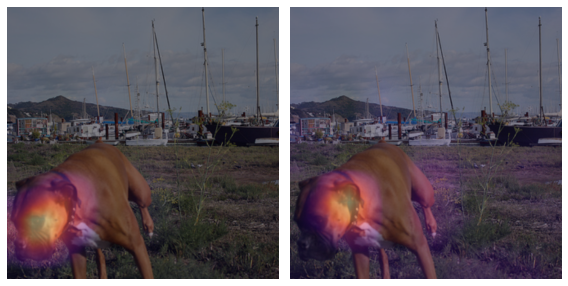

In [51]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [52]:
a1=net(x1).tolist()[0][0]
b1=net(x1).tolist()[0][1]
np.exp(a1)/(np.exp(a1)+np.exp(b1)), np.exp(b1)/(np.exp(a1)+np.exp(b1))

(0.004487248125871372, 0.9955127518741286)

---

## 3rd CNN

- MODE 2 만들기

In [41]:
test1=camimg1[1]-torch.min(camimg1[1])

In [89]:
A3=torch.exp(-0.03*test1)  

In [90]:
A4=1-A3

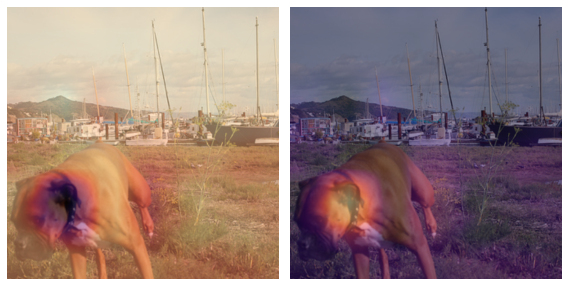

In [91]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A3.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A4.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [92]:
A3.data.to('cpu').shape

torch.Size([16, 16])

In [93]:
X2=np.array(A3.to("cpu").detach(),dtype=np.float32)

In [94]:
Y2=torch.Tensor(cv2.resize(X2,(512,512),interpolation=cv2.INTER_LINEAR))

In [95]:
x2=x1.squeeze().to('cpu')*Y2   #MODE2을 x2로 저장

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


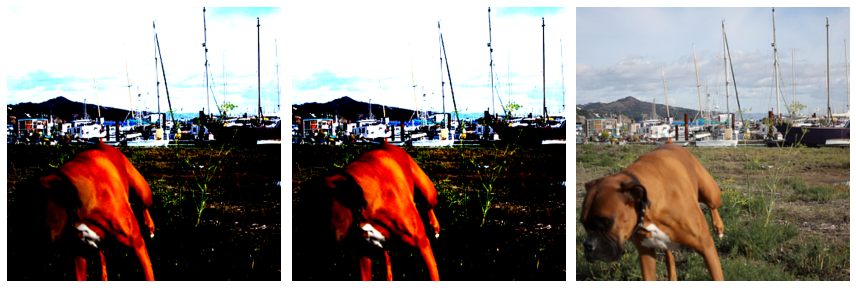

In [96]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
#
x2.show(ax=ax1)  #MODE2
x1.squeeze().show(ax=ax2)  #MODE1
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

In [97]:
x2=x2.reshape(1,3,512,512)

In [98]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [99]:
camimg2 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x2).squeeze())

- CAM

    - mode2에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


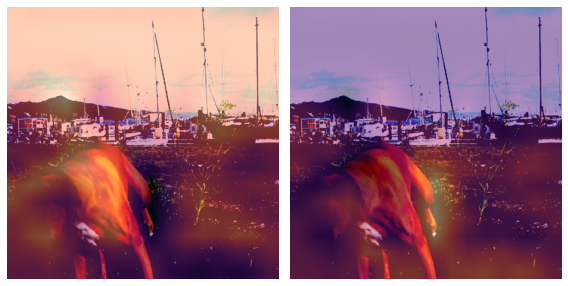

In [100]:
fig, (ax1, ax2) = plt.subplots(1,2) 
x2.squeeze().show(ax=ax1)
ax1.imshow(camimg2[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
x2.squeeze().show(ax=ax2)
ax2.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째, 두번째 CAM결과와 비교

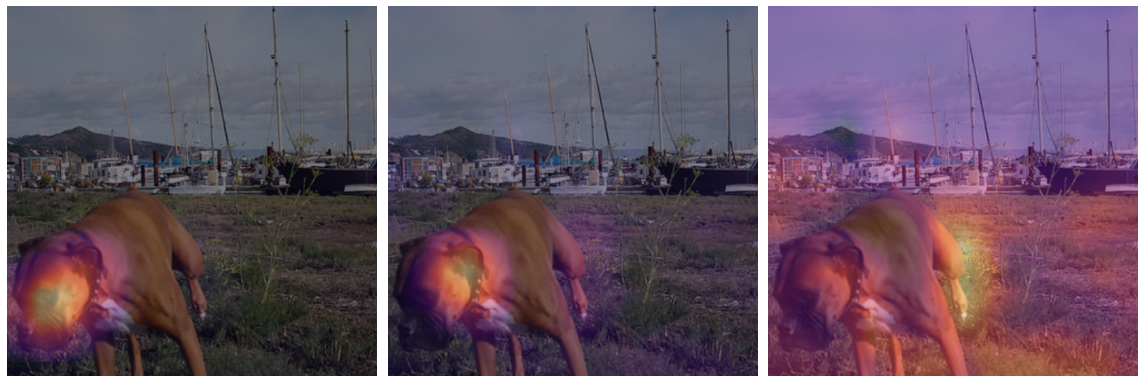

In [101]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [102]:
a2=net(x2).tolist()[0][0]
b2=net(x2).tolist()[0][1]
np.exp(a2)/(np.exp(a2)+np.exp(b2)), np.exp(b2)/(np.exp(a2)+np.exp(b2))

(0.026369678868924343, 0.9736303211310757)

---

## 4th CNN

- MODE 3 만들기

In [72]:
test2=camimg2[1]-torch.min(camimg2[1])

In [131]:
A5=torch.exp(-0.06*test2)  

In [132]:
A6=1-A5

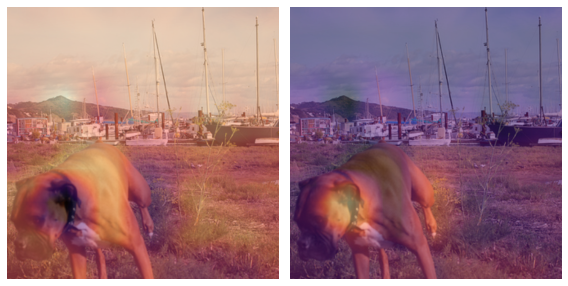

In [133]:
fig, (ax1,ax2) = plt.subplots(1,2) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(A5.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(A6.data.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

In [134]:
A5.data.to('cpu').shape

torch.Size([16, 16])

In [135]:
X3=np.array(A5.to("cpu").detach(),dtype=np.float32)

In [136]:
Y3=torch.Tensor(cv2.resize(X3,(512,512),interpolation=cv2.INTER_LINEAR))

In [137]:
x3=x2.squeeze().to('cpu')*Y3   #MODE3을 x3로 저장

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


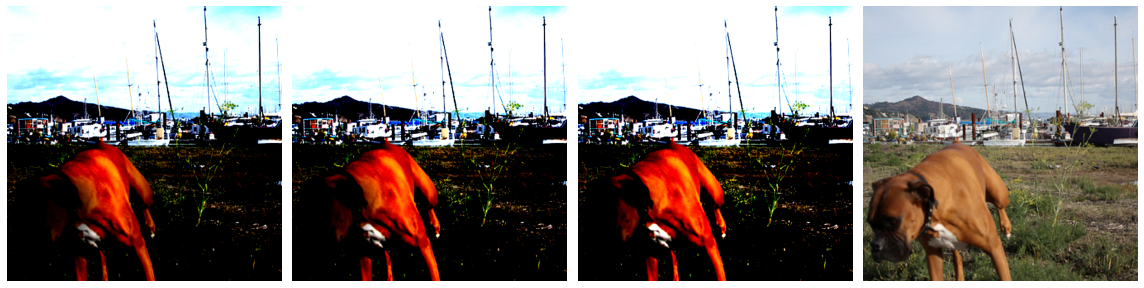

In [138]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4) 
#
x3.show(ax=ax1)  #MODE3
x2.squeeze().show(ax=ax2)  #MODE2
x1.squeeze().show(ax=ax3)  #MODE1
dls.train.decode((x,))[0].squeeze().show(ax=ax4)
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [139]:
x3=x3.reshape(1,3,512,512)

In [140]:
net1.to('cpu')
net2.to('cpu')

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [141]:
camimg3 = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x3).squeeze())

- CAM

    - mode3에 CAM 결과 올리기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


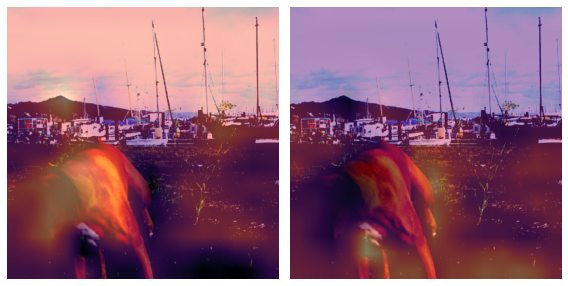

In [142]:
fig, (ax1, ax2) = plt.subplots(1,2) 
x3.squeeze().show(ax=ax1)
ax1.imshow(camimg3[0].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
x3.squeeze().show(ax=ax2)
ax2.imshow(camimg3[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(8)            
fig.set_figheight(8)
fig.tight_layout()

    - 첫번째, 두번째, 세번째 CAM결과와 비교

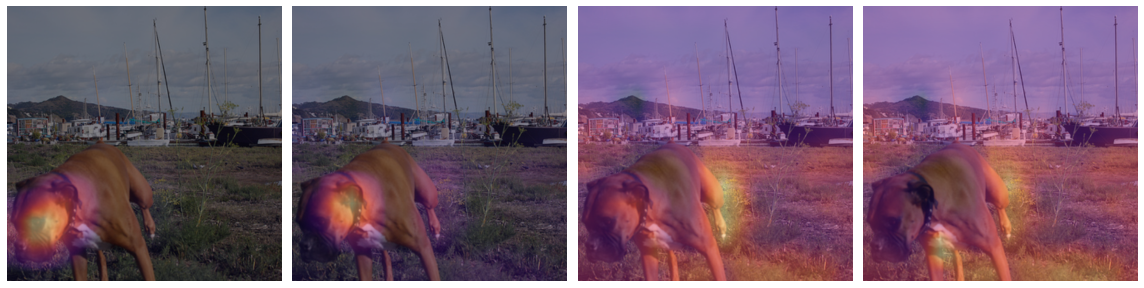

In [143]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.imshow(camimg[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow(camimg1[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow(camimg2[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
#
dls.train.decode((x,))[0].squeeze().show(ax=ax4)
ax4.imshow(camimg3[1].to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [144]:
a3=net(x3).tolist()[0][0]
b3=net(x3).tolist()[0][1]
np.exp(a3)/(np.exp(a3)+np.exp(b3)), np.exp(b3)/(np.exp(a3)+np.exp(b3))

(0.052085219034464114, 0.9479147809655359)

--- 

- CNN, CAM 횟수가 증가함에 따라 `exp(-k*test)`의 k를 2배씩 해주었음.$\to$ 2배로 증가시키니 k값을 유지했을 때보다 강아지라고 인식한 곳이 잘 이동함.

- lrnr2 epoch수를 늘려 과적합시킬수록 강아지라고 인식한 곳의 이동이 확연히 드러남.